In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from ipywidgets import widgets
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Data Processing and Exploratory Data Analysis:

The data is from https://data.cdc.gov/NCHS/Mental-Health-Care-in-the-Last-4-Weeks/yni7-er2q/about_data for the purpose to learn about mental health situation in COVID period among ages, groups, genders, geographical regions, etc. In the end this notebook will analyze possible co-relationship, and potential factors.

The dataset can also be accessed through this [link](https://drive.google.com/file/d/1blmKKAgqETSu9_1oI2_clG4OvK52C0Fd/view?usp=sharing)

In [ ]:
raw_data = pd.read_csv("/content/Mental_Health_Care_in_the_Last_4_Weeks_20240126.csv")
raw_data.head()

,Indicator,Group,State,Subgroup,Phase,Time Period,Time Period Label,Time Period Start Date,Time Period End Date,Value,LowCI,HighCI,Confidence Interval,Quartile Range,Suppression Flag
0,Took Prescription Medication for Mental Health...,National Estimate,United States,United States,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,08/31/2020,19.4,19.0,19.8,19.0 - 19.8,NaN,NaN
1,Took Prescription Medication for Mental Health...,By Age,United States,18 - 29 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,08/31/2020,18.7,17.2,20.3,17.2 - 20.3,NaN,NaN
2,Took Prescription Medication for Mental Health...,By Age,United States,30 - 39 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,08/31/2020,18.3,17.3,19.2,17.3 - 19.2,NaN,NaN
3,Took Prescription Medication for Mental Health...,By Age,United States,40 - 49 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,08/31/2020,20.4,19.5,21.3,19.5 - 21.3,NaN,NaN
4,Took Prescription Medication for Mental Health...,By Age,United States,50 - 59 years,2,13,"Aug 19 - Aug 31, 2020",08/19/2020,08/31/2020,21.2,20.2,22.2,20.2 - 22.2,NaN,NaN


In [ ]:
raw_data.shape

(10404, 15)

The data is 10404 rows with 15 columns.

In [ ]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10404 entries, 0 to 10403
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Indicator               10404 non-null  object 
 1   Group                   10404 non-null  object 
 2   State                   10404 non-null  object 
 3   Subgroup                10404 non-null  object 
 4   Phase                   10404 non-null  object 
 5   Time Period             10404 non-null  int64  
 6   Time Period Label       10404 non-null  object 
 7   Time Period Start Date  10404 non-null  object 
 8   Time Period End Date    10404 non-null  object 
 9   Value                   9914 non-null   float64
 10  LowCI                   9914 non-null   float64
 11  HighCI                  9914 non-null   float64
 12  Confidence Interval     9914 non-null   object 
 13  Quartile Range          6732 non-null   object 
 14  Suppression Flag        22 non-null   

Columns like `Value, LowCI, HighCI` have some missing values that possibly need to be handled with.

In [ ]:
raw_data["Group"].unique()

array(['National Estimate', 'By Age', 'By Sex',
       'By Presence of Symptoms of Anxiety/Depression',
       'By Race/Hispanic ethnicity', 'By Education', 'By State',
       'By Disability status', 'By Gender identity',
       'By Sexual orientation'], dtype=object)

In [ ]:
raw_data["Indicator"].unique()

array(['Took Prescription Medication for Mental Health, Last 4 Weeks',
       'Received Counseling or Therapy, Last 4 Weeks',
       'Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks',
       'Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks'],
      dtype=object)

Look into the data: \
`group` seems can be used to categorize observations, and `subgroup`s are detailed categories for each group. For example, if one observation has a group called `BY Age` and then its `subgroup` shoud be a detailed age range: i.e. 18-29 years. `State` can be used for geographical analysis. \
Deeper analysis on `Group` column: \
each unique value can represent a category - or a factor that can affect mental health and whether or not the survey participant has received professional support - `Indicator` column.

In [ ]:
# Array of unique values
unique_values = ['National Estimate', 'By Age', 'By Sex',
                 'By Presence of Symptoms of Anxiety/Depression',
                 'By Race/Hispanic ethnicity', 'By Education', 'By State',
                 'By Disability status', 'By Gender identity',
                 'By Sexual orientation']

data = []
# Loop through each unique value to get the observation counts
for value in unique_values:
    observation_count = raw_data[raw_data["Group"] == value].shape[0]
    data.append({'Group': value, 'Observation_Count': observation_count})

# Convert the list of dictionaries to a DataFrame
summary_df = pd.DataFrame(data)
summary_df

,Group,Observation_Count
0,National Estimate,152
1,By Age,1064
2,By Sex,304
3,By Presence of Symptoms of Anxiety/Depression,304
4,By Race/Hispanic ethnicity,760
5,By Education,608
6,By State,6732
7,By Disability status,168
8,By Gender identity,156
9,By Sexual orientation,156


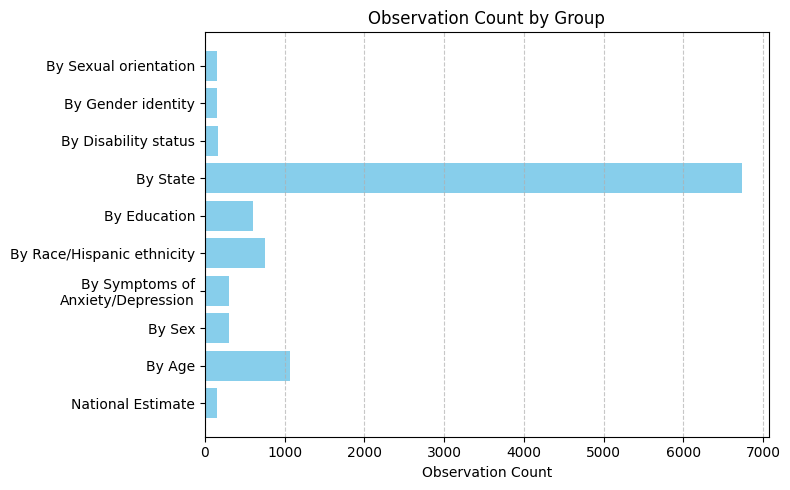

In [ ]:
abbreviated_labels = [label.replace('By Presence of Symptoms of Anxiety/Depression',
                                   'By Symptoms of\nAnxiety/Depression') for label in summary_df['Group']]
plt.figure(figsize=(8, 5))
plt.barh(abbreviated_labels, summary_df['Observation_Count'], color='skyblue')
plt.xlabel('Observation Count')
plt.title('Observation Count by Group')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

We will exclude National Estimate because all observations are from US.\
So we have in total 9 factors to analyze and see if they have relationship with mental health issues. Other than that Time Period can also be a factor that contributes to different levels of mental health problem - the `Indicator` column and `Value` column.

# Visualizations, Patterns, and Missing Values:

In [ ]:
raw_data[raw_data["Value"].isnull()]["Group"].unique()

array(['By Age', 'National Estimate', 'By Sex',
       'By Presence of Symptoms of Anxiety/Depression',
       'By Race/Hispanic ethnicity', 'By Education', 'By State',
       'By Disability status', 'By Gender identity',
       'By Sexual orientation'], dtype=object)

Because our dataset may have inner relationship between groups and value, and each group may have clear boundries.

In [ ]:
unique_values = ['By Age', 'National Estimate', 'By Sex',
       'By Presence of Symptoms of Anxiety/Depression',
       'By Race/Hispanic ethnicity', 'By Education', 'By State',
       'By Disability status', 'By Gender identity',
       'By Sexual orientation']

null_data = raw_data[raw_data["Value"].isnull()]
data = []
for value in unique_values:
    null_count = null_data[null_data["Group"] == value].shape[0]
    data.append({'Group': value, 'Null_Count': null_count})

null_summary_df = pd.DataFrame(data)
null_summary_df

,Group,Null_Count
0,By Age,153
1,National Estimate,20
2,By Sex,40
3,By Presence of Symptoms of Anxiety/Depression,40
4,By Race/Hispanic ethnicity,100
5,By Education,80
6,By State,9
7,By Disability status,24
8,By Gender identity,12
9,By Sexual orientation,12


Now let's try fill in null as 0 and visualize them.

In [ ]:
copy_raw_data = raw_data.copy()
copy_raw_data.fillna(value=0, inplace=True)

In [ ]:
age_data = copy_raw_data[copy_raw_data["Group"] == "By Age"]

traces = []
sub_groups = age_data['Subgroup'].unique()
indicators = age_data['Indicator'].unique()
trace_visibility = dict()

# Create a scatter plot trace for each combination of 'Subgroup' and 'Indicator'
for indicator in indicators:
    for sub_group in sub_groups:
        sub_group_data = age_data[(age_data['Subgroup'] == sub_group) & (age_data['Indicator'] == indicator)]
        trace_name = f"{indicator} - {sub_group}"
        trace_visibility[trace_name] = False  # Initialize all traces as invisible
        traces.append(go.Scatter(
            x=sub_group_data["Time Period"],
            y=sub_group_data['Value'],
            mode='markers',
            name=trace_name
        ))

buttons = []

# Add buttons for each 'Indicator'
for indicator in indicators:
    # Set visibility to True for traces that match the current indicator
    args_visibility = [trace_name.startswith(indicator) for trace_name in trace_visibility]
    buttons.append(dict(
        args=[{"visible": args_visibility}],
        label=indicator,
        method="update"
    ))

# Add buttons for each 'Subgroup' within each 'Indicator'
for indicator in indicators:
    for sub_group in sub_groups:
        # Set visibility to True for the current combination of indicator and subgroup
        args_visibility = [(trace_name == f"{indicator} - {sub_group}") for trace_name in trace_visibility]
        buttons.append(dict(
            args=[{"visible": args_visibility}],
            label=f"{indicator} - {sub_group}",
            method="update"
        ))

# Add a button to show all traces
buttons.append(dict(
    args=[{"visible": [True] * len(traces)}],
    label="All",
    method="update"
))

# Create a layout with a dropdown menu
layout = go.Layout(
    title='Scatter Plot of Value by Age Subgroups and Indicator',
    xaxis={'title': 'Time Period'},
    yaxis={'title': 'Value'},
    showlegend=True,
    updatemenus=[{
        "buttons": buttons,
        "direction": "down",
        "pad": {"r": 10, "t": 10},
        "showactive": True,
        "x": 0.1,
        "xanchor": "left",
        "y": 1.1,
        "yanchor": "top"
    }]
)

fig = go.Figure(data=traces, layout=layout)
fig.show()

We can tell that all missing values for the age groups are 80 years and above, in detail include "Received Counseling or Therapy, Last 4 Weeks - 80 years and above" and "Needed Counseling or Therapy, Last 4 Weeks - 80 years and above" these two categories, and mostly follow the linear regression pattern. So we can build a regression model and try the ***Interpolation*** method.

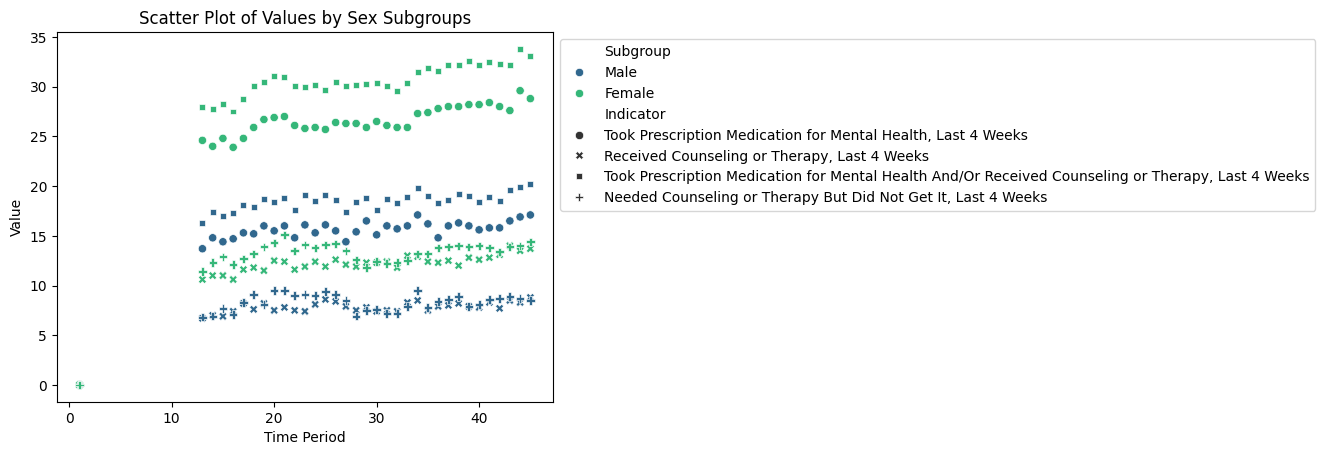

In [ ]:
sex_data = copy_raw_data[copy_raw_data["Group"] == "By Sex"]

# plt.figure(figsize=(10, 6))
ax = sns.scatterplot(data=sex_data, x="Time Period", y="Value", hue="Subgroup", style="Indicator", palette="viridis")

plt.title('Scatter Plot of Values by Sex Subgroups')
plt.xlabel('Time Period')
plt.ylabel('Value')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# First, we'll one-hot encode the categorical columns.
df = raw_data.copy()
df_encoded = pd.get_dummies(df[['Indicator', 'Subgroup', "Value", "Group"]], columns=['Indicator', 'Subgroup', 'Group'])
df_encoded["Time Period"] = df["Time Period"]

# Seperate features and prediction value (y)
X = df_encoded.drop('Value', axis=1)
y = df_encoded['Value'].dropna()

# To interpolate missing values, we'll use only rows where 'value' is not missing for training
X_train = X.loc[y.index]

# Define and train the model
model = LinearRegression()

In [ ]:
# Test how the prediction is
# Because this batch of dataset is relatively small, we will try to use cross-validation here to find a more accurate performance metric
kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metrics = ['neg_mean_absolute_error', 'neg_mean_squared_error', 'r2']
# Perform cross-validation
for metric in scoring_metrics:
    scores = cross_val_score(model, X_train, y, scoring=metric, cv=kf)
    print(f"{metric}: {scores.mean()} (std: {scores.std()})")

neg_mean_absolute_error: -2.0273388369003853 (std: 0.031019592315023593)
neg_mean_squared_error: -6.801404401129142 (std: 0.2922428636154243)
r2: 0.900434179832222 (std: 0.0043954673584831495)


In [ ]:
model.fit(X_train, y)
# Predict the missing values
X_missing = X[df['Value'].isnull()]
predicted_values = model.predict(X_missing)

# Fill in the missing values
df.loc[df['Value'].isnull(), 'Value'] = predicted_values

In [ ]:
df.to_csv("cleaned_data.csv")

# Tableau Visualization and Discoveriea:

Now we have cleaned data called `df`. We can draw more interesting graphs via Tableau.
Dashboard [Link](https://public.tableau.com/authoring/NCHSMentalHealthHouseholdPulseSurvey/Dashboard#1)

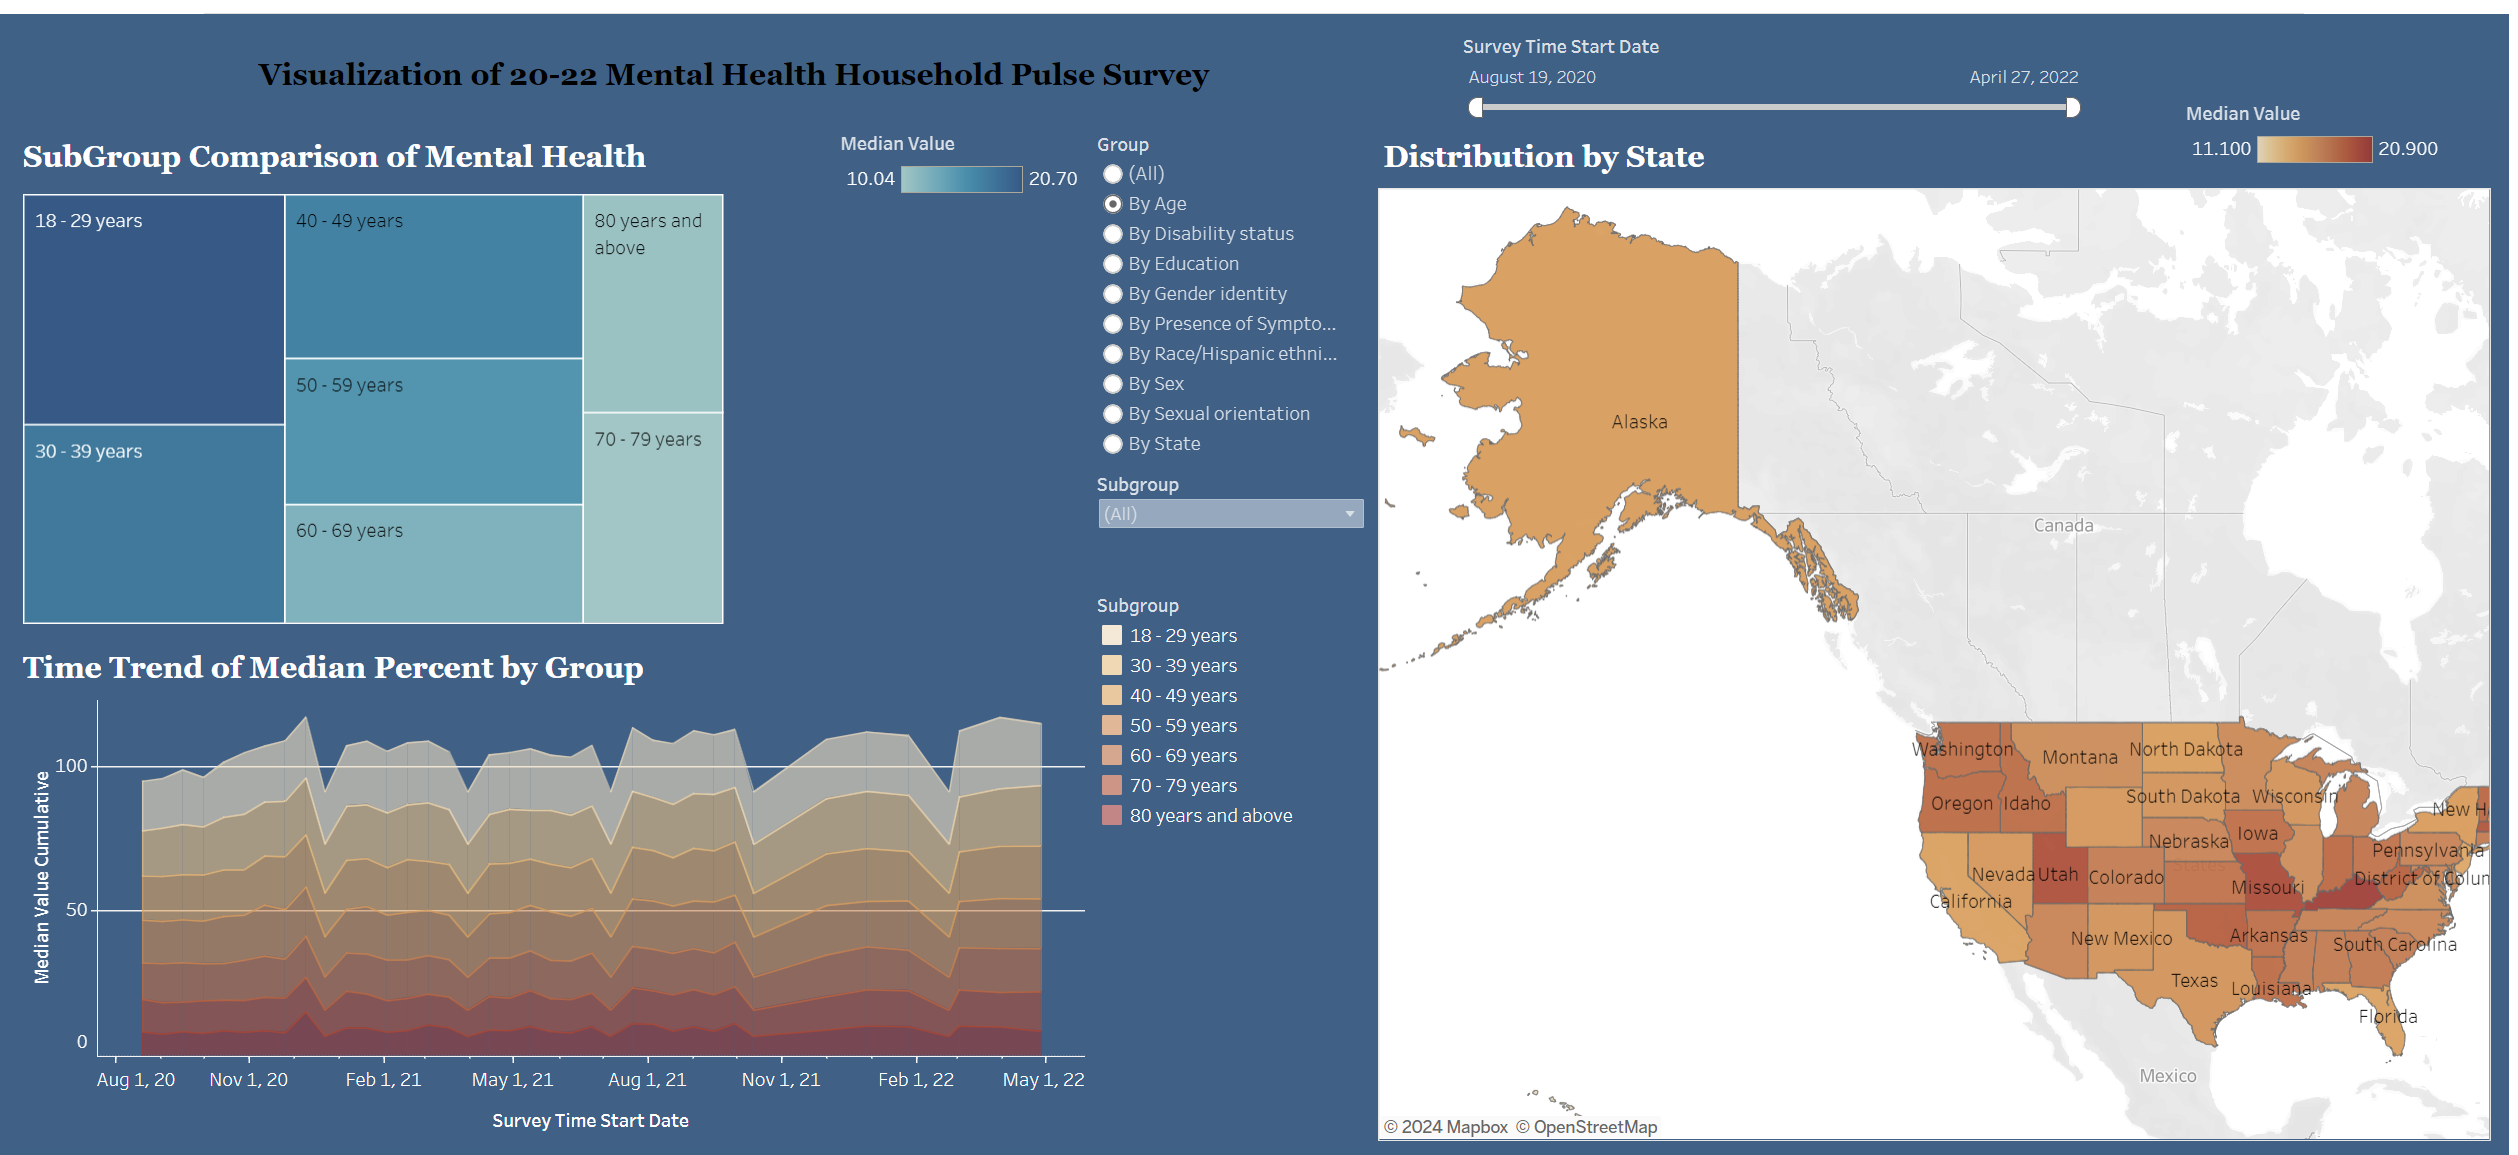

The visualizations clearly demonstrate that mental health concerns have risen from 2020 to 2021. It's evident that the age groups of 18-29 and 40-49 show relatively higher rates of mental health issues. Interestingly, the 50-59 age group seems to be receiving more consistent mental health support, particularly through prescription medication.

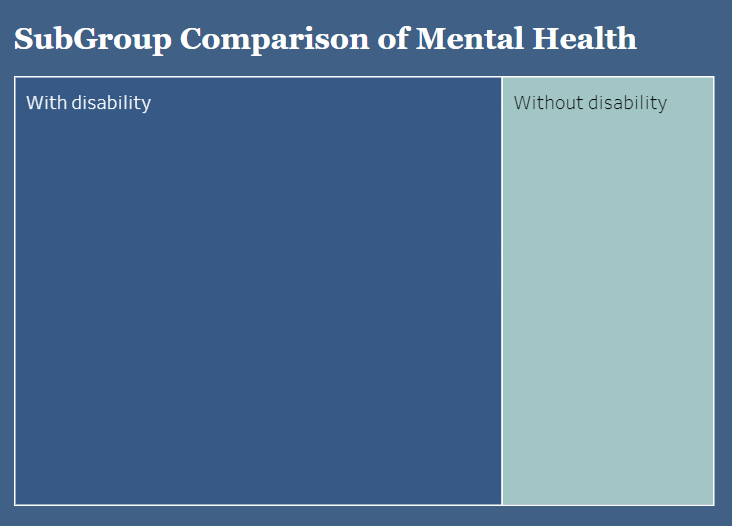

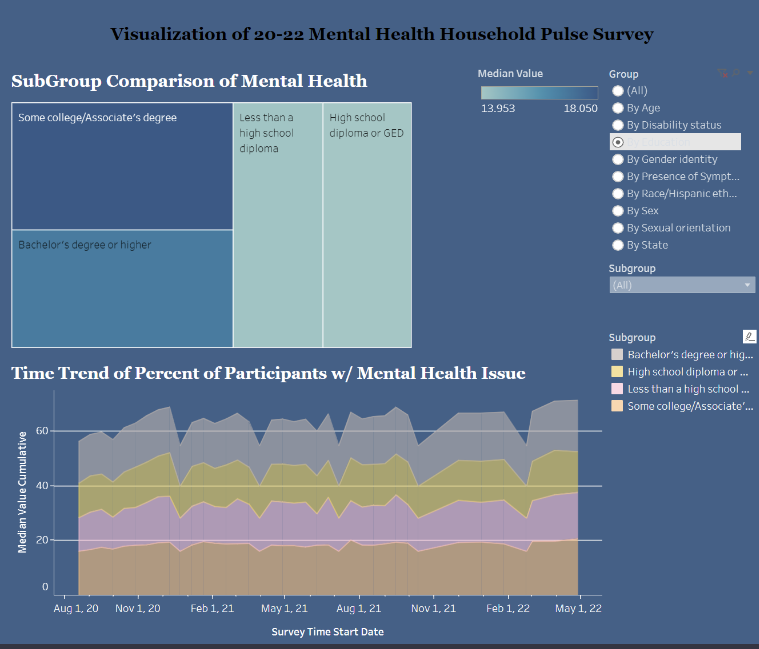

Those with disabilities are shown to have a higher prevalence of mental health issues, which suggests an intersectional approach is needed in mental health services. The data also reflects that individuals with higher educational attainment are more likely to seek help for mental health concerns.

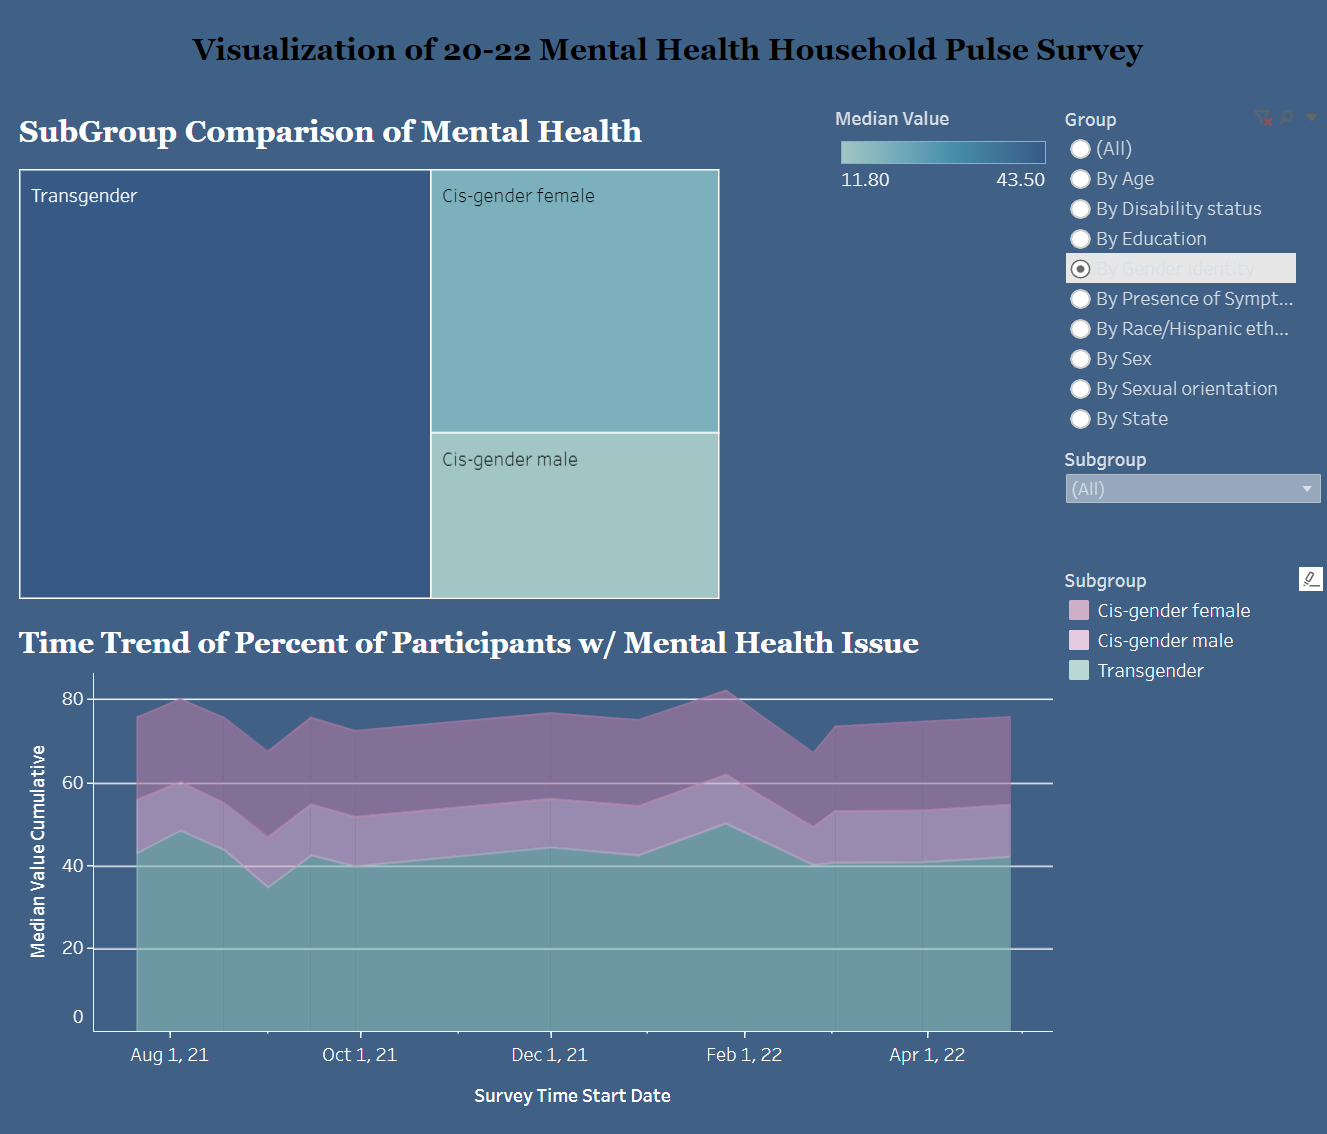

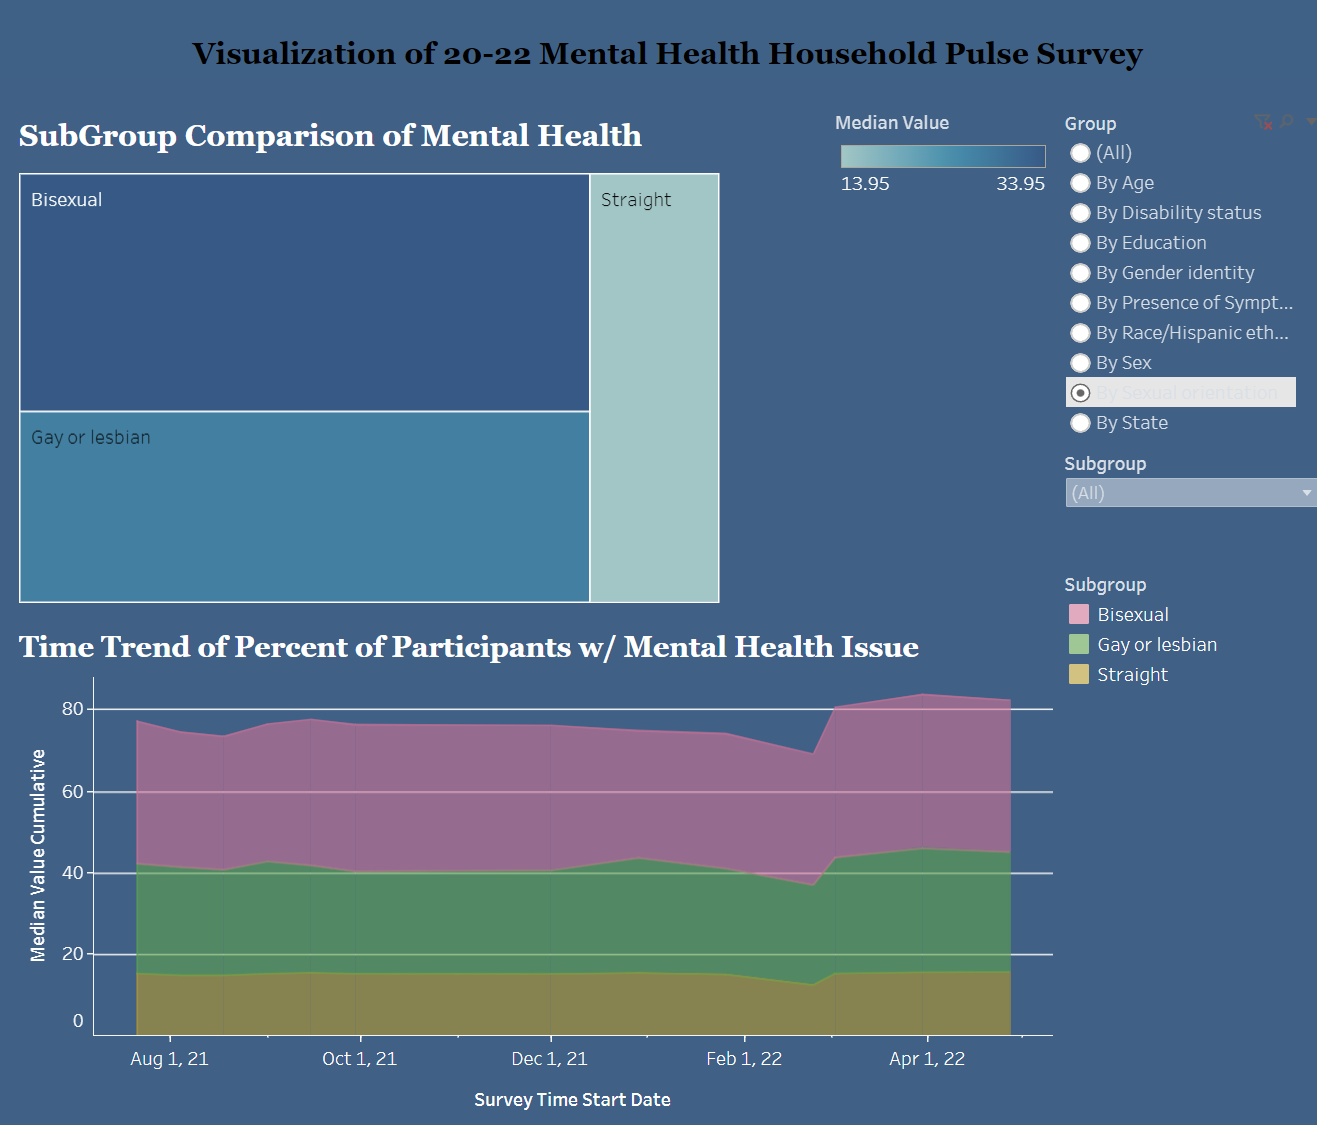

Sexual orientation appears to play a role, with minority groups facing more challenges in mental health, potentially indicating underlying social stresses such as discrimination. The transgender community, in particular, shows a significantly higher median rate of mental health concerns compared to cisgender individuals, highlighting a crucial need for inclusive support.

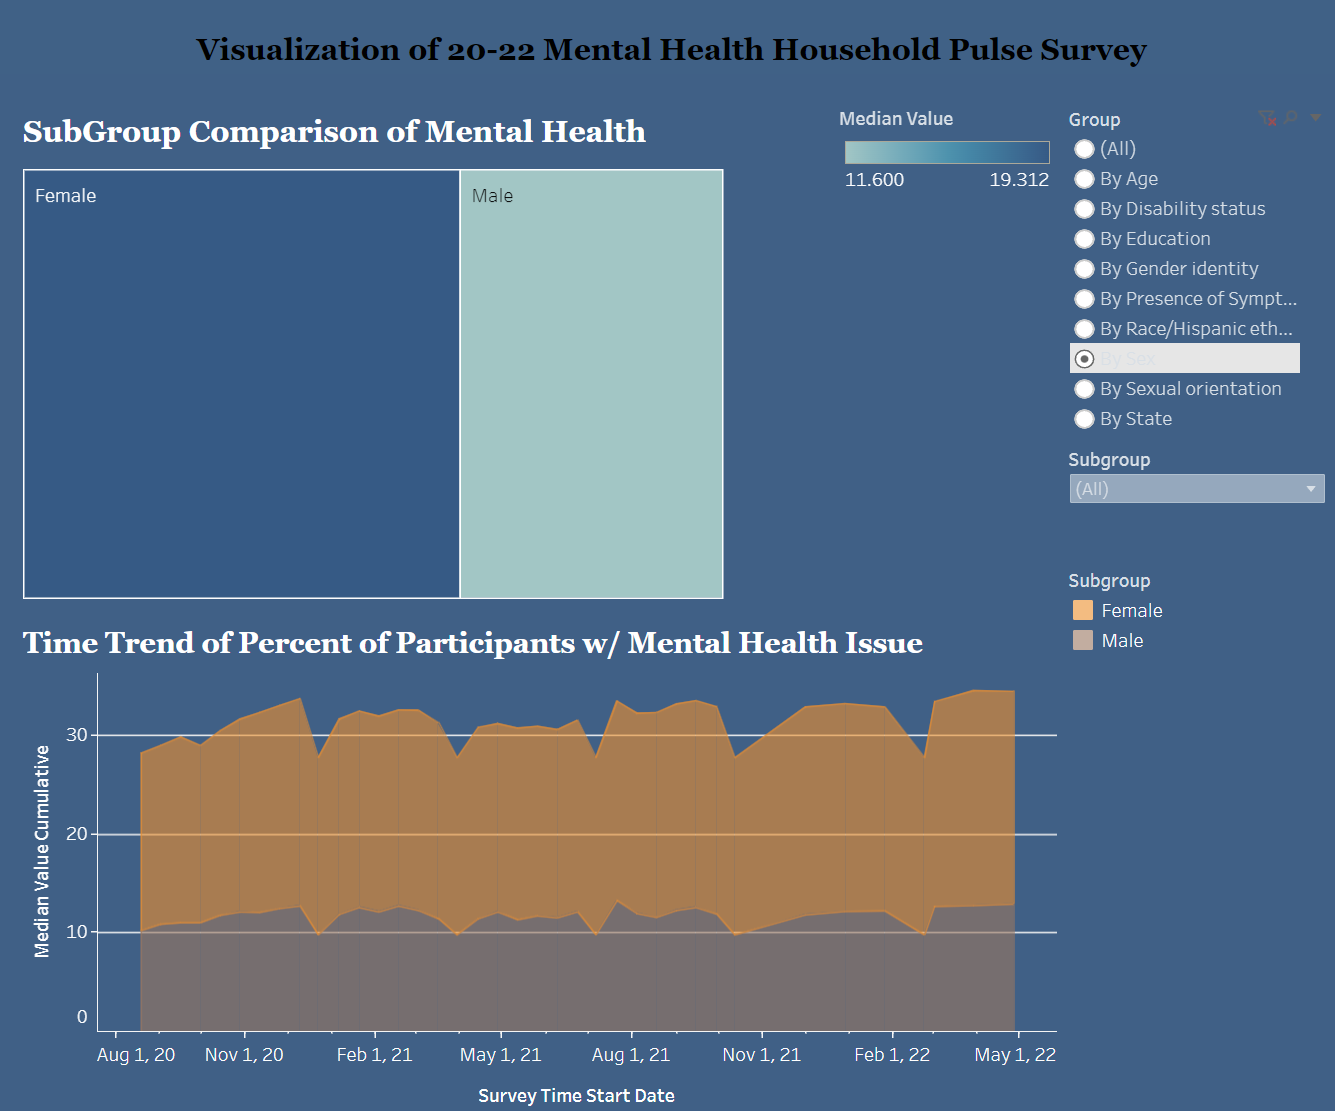

Female group also has higher percentage of population that expericienced mental health problems especially during the COVID period, either due to gender inequalities in accessibilities of professional support, or due to the biological difference or different personal experience from male group.

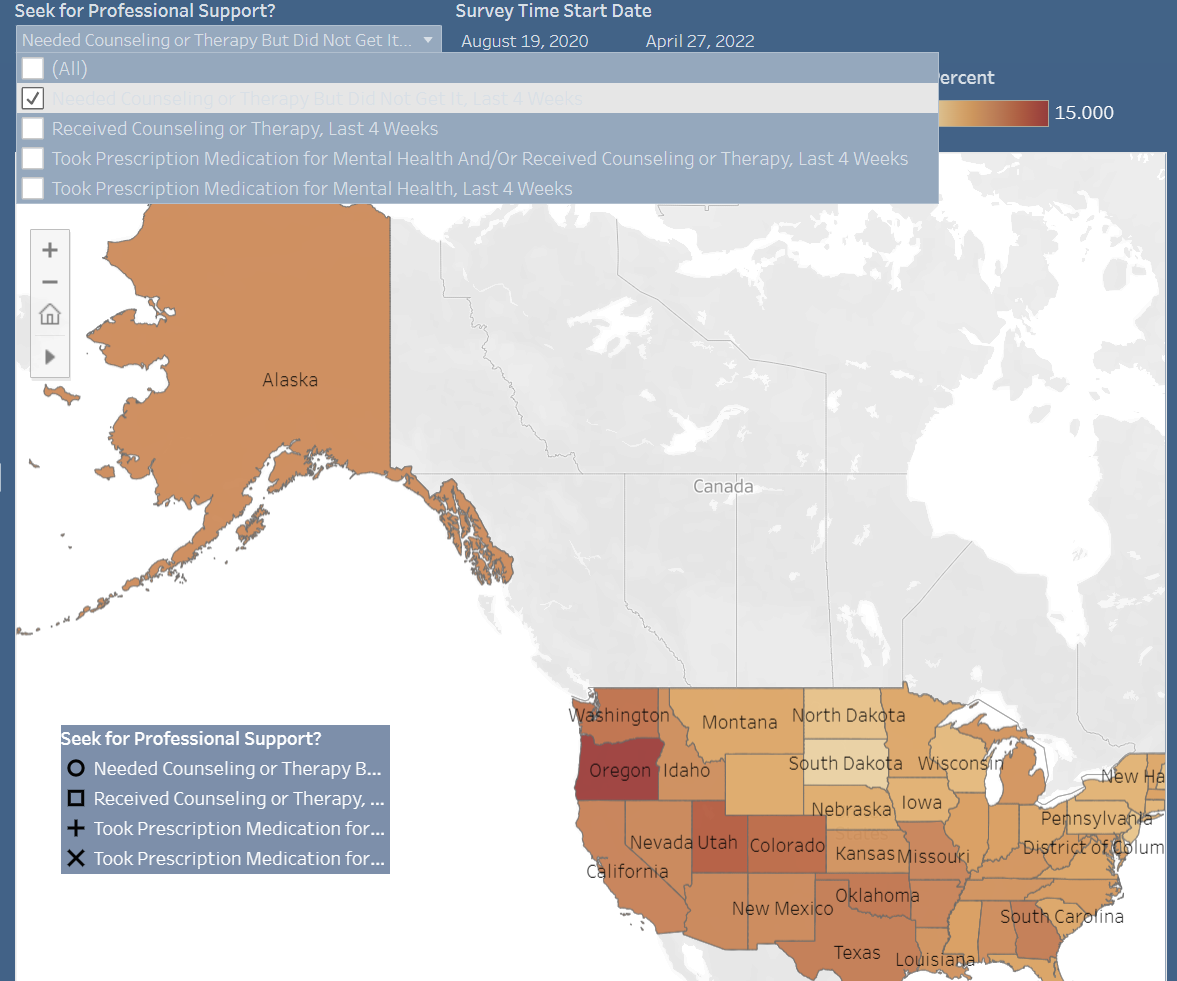

Geographically, the states of Oregon, Utah, Colorado, and Washington show a higher percentage of people who have unmet needs for mental health support. This finding suggests potential areas where healthcare accessibility and services could be improved.

# Conclusion：

*The analysis of the Mental Health Household Pulse Survey Data reveals a growing prevalence of mental health issues across various demographics from 2020 to 2021, with notable variances in age, disability status, education level, gender identity, sexual orientation, and by state. Individuals aged 18-29 and 40-49 are particularly affected, while those aged 50-59 seem to access consistent support, notably through medication. The increased rates of mental health challenges among the disabled and transgender populations highlight a need for specialized, accessible mental health services. Higher educational attainment correlates with increased help-seeking behavior, suggesting that educational initiatives could foster wider access to mental health resources. Minority sexual orientation groups report heightened mental health challenges, potentially indicative of broader societal pressures. States like Oregon, Utah, Colorado, and Washington show significant numbers of residents with unmet mental health support needs, pointing towards potential systemic gaps in service provision and accessibility.*

To address these findings, strategies may include:

*   Developing targeted mental health programs for high-risk age groups.
*   Expanding telehealth services to improve access in states identified with unmet needs.
*   Implementing educational campaigns to reduce stigma and promote mental health literacy across all educational levels.
*   Strengthening support for minority groups, with specific attention to culturally competent care that addresses the unique challenges faced by these populations.
*   Advocating for policy changes to ensure healthcare systems are inclusive and equipped to serve diverse gender identities effectively.
*   Increasing research into the social determinants of mental health to inform more equitable healthcare policies.
